# ICT Project: Communication Services and Security
## Exercise 2
### Albert Pérez Datsira

In [1]:
# there is a requirements.txt file which contains the output of a `pip freeze` command
# you may install the dependencies to run this notebook into your machine
# or create a python 3 virtual environment
# pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Reading the trace files
#### sim-trace.tr

In [3]:
# this is how the data will be structured
trace_format = [
    'Event_Type', 
    'Time', 
    'Src_Node', 
    'Dst_Node', 
    'Pckt_Type', 
    'Pckt_Size', 
    'Flags', 
    'Flow_Identifier', 
    'Src_Address', 
    'Dst_Address', 
    'Pckt_Number', 
    'Pckt_Identifier']

df_trace = pd.read_csv('sim-trace.tr', sep=' ', names = trace_format) # importing the data into a pandas.dataframe
df_trace.head() # show first 5 rows

,Event_Type,Time,Src_Node,Dst_Node,Pckt_Type,Pckt_Size,Flags,Flow_Identifier,Src_Address,Dst_Address,Pckt_Number,Pckt_Identifier
0,+,0.0,0,3,tcp,40,-------,0,0.0,4.0,0,0
1,-,0.0,0,3,tcp,40,-------,0,0.0,4.0,0,0
2,+,0.0,1,3,tcp,40,-------,1,1.0,4.1,0,1
3,-,0.0,1,3,tcp,40,-------,1,1.0,4.1,0,1
4,+,0.0,2,3,tcp,1000,-------,2,2.0,4.2,0,2


In [4]:
df_trace.info() # get dataframe info, to see if its needed to clean
# but, as seen, all types are correctly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28519 entries, 0 to 28518
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Event_Type       28519 non-null  object 
 1   Time             28519 non-null  float64
 2   Src_Node         28519 non-null  int64  
 3   Dst_Node         28519 non-null  int64  
 4   Pckt_Type        28519 non-null  object 
 5   Pckt_Size        28519 non-null  int64  
 6   Flags            28519 non-null  object 
 7   Flow_Identifier  28519 non-null  int64  
 8   Src_Address      28519 non-null  float64
 9   Dst_Address      28519 non-null  float64
 10  Pckt_Number      28519 non-null  int64  
 11  Pckt_Identifier  28519 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 2.6+ MB


#### sim-trace.rtt

In [5]:
metrics_format = [
    'Node',
    'Time',
    'rtt',
    'srtt', 
    'cwnd', 
    'cwmax', 
    'bo'] # values collected

df_metrics = pd.read_csv('sim-trace.rtt', sep=' ', names = metrics_format)
df_metrics.head()

,Node,Time,rtt,srtt,cwnd,cwmax,bo
0,0,0.0,0.0,0.0,1.0,40,0.0
1,1,0.0,0.0,0.0,1.0,40,0.0
2,2,0.0,0.0,0.0,1.0,40,0.0
3,0,0.1,0.0,0.0,1.0,40,0.0
4,1,0.1,0.0,0.0,1.0,40,0.0


### Lost packets

In [6]:
lost_pckts = df_trace.Event_Type == 'd' # get lots packets by mapping those ones with event_type == 'd' (dropped)
ids = df_trace[lost_pckts].Flow_Identifier # filter by the flow_identifier (class)
# we could also filter by Src_Address, as we need the packets dropped by the n3

n0_lost = sum(ids == 0) # TCP Tahoe
n1_lost = sum(ids == 1) # TCP Reno
n2_lost = sum(ids == 2) # TCP Vegas

In [7]:
print("Lost Packets")
print("Node 0, TCP Tahoe:\t", n0_lost)
print("Node 1, TCP Reno:\t", n1_lost)
print("Node 2, TCP Vegas:\t", n2_lost)
print("Total: ", ids.count())

Lost Packets
Node 0, TCP Tahoe:	 10
Node 1, TCP Reno:	 11
Node 2, TCP Vegas:	 1
Total:  22


### Transferred bytes

In [8]:
def mapNode(row, node):
  return row.Src_Node == int(node) and row.Event_Type == '-' # mapping condition

n0_pckts = df_trace.apply(mapNode, axis = 1, args=('0'))
n1_pckts = df_trace.apply(mapNode, axis = 1, args=('1'))
n2_pckts = df_trace.apply(mapNode, axis = 1, args=('2'))
n3_pckts = df_trace.apply(mapNode, axis = 1, args=('3'))
n4_pckts = df_trace.apply(mapNode, axis = 1, args=('4'))

n0_bytes = sum(df_trace[n0_pckts].Pckt_Size)
n1_bytes = sum(df_trace[n1_pckts].Pckt_Size)
n2_bytes = sum(df_trace[n2_pckts].Pckt_Size)
n3_bytes = sum(df_trace[n3_pckts].Pckt_Size)
n4_bytes = sum(df_trace[n4_pckts].Pckt_Size)
total_bytes = n0_bytes + n1_bytes + n2_bytes + n3_bytes + n4_bytes

In [9]:
print("Transferred bytes:")
print("Node 0, TCP Tahoe:\t", n0_bytes)
print("Node 1, TCP Reno:\t", n1_bytes)
print("Node 2, TCP Vegas:\t", n2_bytes)
print("Node 3:\t", n3_bytes)
print("Node 4:\t", n4_bytes)
print("Total Agents:\t", n0_bytes + n1_bytes + n2_bytes)
print("Total Scenario:\t", total_bytes)

Transferred bytes:
Node 0, TCP Tahoe:	 766520
Node 1, TCP Reno:	 759240
Node 2, TCP Vegas:	 940000
Node 3:	 2517600
Node 4:	 94440
Total Agents:	 2465760
Total Scenario:	 5077800


### Congestion Window visualization

In [10]:
# get cwnd values
cwnd0 = df_metrics[df_metrics.Node == 0].cwnd
cwnd1 = df_metrics[df_metrics.Node == 1].cwnd
cwnd2 = df_metrics[df_metrics.Node == 2].cwnd
time = df_metrics[df_metrics.Node == 0].Time

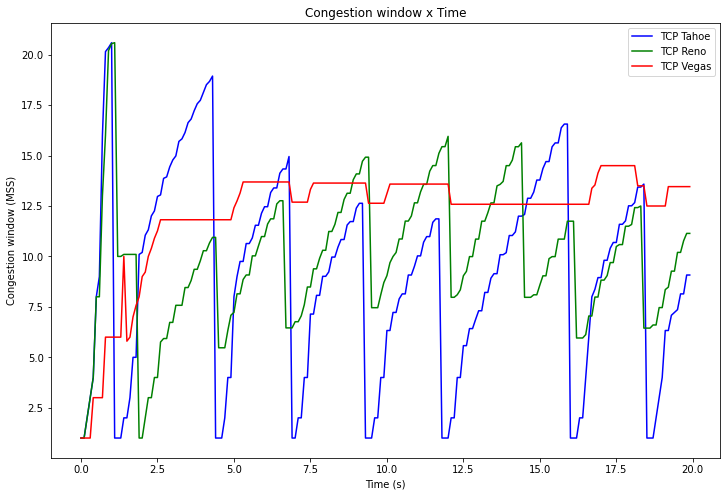

In [11]:
plt.figure(figsize=(12,8))
plt.plot(time, cwnd0, label='TCP Tahoe', color='blue')
plt.plot(time, cwnd1, label='TCP Reno', color='green')
plt.plot(time, cwnd2, label='TCP Vegas', color='red')

plt.title('Congestion window x Time')
plt.xlabel('Time (s)')
plt.ylabel('Congestion window (MSS)')
plt.legend(loc='upper right')
plt.savefig("cwnd-plot.png")
plt.show()